In [1]:
import numpy as np 
import pandas as pd 
import duckdb as db
conn = db.connect()
import matplotlib.pyplot as plt

Read in main table:

In [2]:
apps = conn.execute(
    """
    DROP TABLE IF EXISTS apps;
    CREATE TABLE apps AS
        SELECT * FROM read_csv_auto('data/application_train.csv');
    SELECT * FROM apps;
    """
).fetchdf()

In [3]:
apps.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


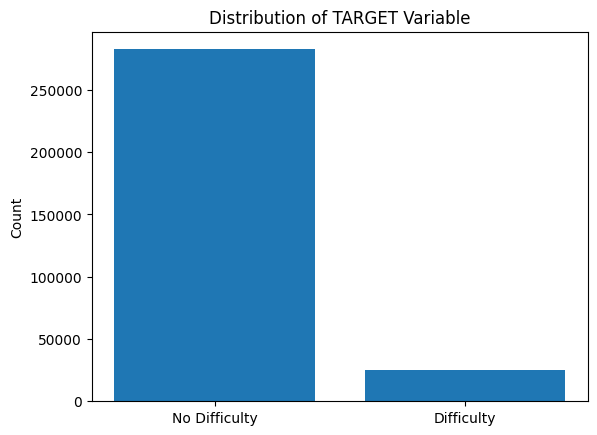

In [4]:
# plot value counts of TARGET column
target_counts = apps['TARGET'].value_counts()
plt.bar(target_counts.index, target_counts.values)
plt.xticks(target_counts.index, ['No Difficulty', 'Difficulty'])
plt.ylabel('Count')
plt.title('Distribution of TARGET Variable')
plt.show()

Very imbalanced, will have to consider oversampling or undersamping later


## Missing Value Handling

First, I'm going to try to fill in some of the missing entries that actually have meaning (e.g. missing a car-related variable means they don't own a car)

In [5]:
# when ext_source is missing, fill with mean of other ext_sources
ext_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
apps["EXT_SOURCE_MEAN"] = apps[ext_cols].mean(axis=1, skipna=True) # the mean itself could be useful as well
apps["EXT_SOURCE_MEAN"] = apps["EXT_SOURCE_MEAN"].fillna(apps["EXT_SOURCE_MEAN"].median()) # edge case where all 3 are missing
for col in ext_cols:
    apps[col] = apps[col].fillna(apps["EXT_SOURCE_MEAN"]) # fill missing sources with mean of all sources

# missing car age means they don't have a car (there is already a flag for owning a car so no need to make a new one)
apps["OWN_CAR_AGE"] = apps["OWN_CAR_AGE"].fillna(0) # age = 0 = no car

# so many property-related columns where if missing, means they don't have that property
## current solution: a mean of proprerty-related columns and missingness proportion as features
property_cols = [c for c in apps.columns if "_AVG" in c or "_MEDI" in c or "_MODE" in c]
numeric_property_cols = apps[property_cols].select_dtypes(include=["number"]).columns
apps["PROPERTY_METRIC"] = apps[numeric_property_cols].mean(axis=1)
apps["PROPERTY_MISSING_PROP"] = apps[numeric_property_cols].isna().mean(axis=1)

# fill missing categorical property stuff with unknown (house type, wall material, etc.)
categorical_property_cols = apps[property_cols].select_dtypes(include=["object"]).columns
for col in categorical_property_cols:
    apps[col] = apps[col].fillna("UNKNOWN")

I either imputed or aggregated for all interesting features I could find with >50% missing values. So now I will drop any remaining.

In [6]:
apps = apps.loc[:, apps[apps['TARGET'] == 1].isnull().mean() < 0.5]
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

Now the data is pretty much full except for a few columns. 

- `AMT_REQ_CREDIT_BUREAU_{}`
    - 0 means no credit checks
    - missing is different, it means they don't have info from the bureau on credit checks
    - fill in with 0 but also add a flag for missing?
    - and calculate total credit checks for a simpler feature
- `OCCUPATION_TYPE`
    - missing could be anything: unemployed, retired, student, just unknown...
    - could be meaningful, so don't remove
    - impute with 'unknown'
- **Social circle columns**
    - Small % of missing values, but only one left with any real amount of missing
    - Missing means no social data for this client
    - Reasonably fill with 0?

In [7]:
# bureau credit checks: add missing flag, impute with 0, and sum total requests
bureau_cols = [
    "AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"
]
apps["BUREAU_REQ_MISSING"] = apps[bureau_cols].isna().any(axis=1).astype(int)
apps[bureau_cols] = apps[bureau_cols].fillna(0)
apps["BUREAU_REQ_TOTAL"] = apps[bureau_cols].sum(axis=1, skipna=True)

# occupation type: impute with unknown
apps["OCCUPATION_TYPE"] = apps["OCCUPATION_TYPE"].fillna("Unknown")

# social circle columns: fill with 0
social_cols = [
    "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE"
]
apps[social_cols] = apps[social_cols].fillna(0)
# calculate the default rates and totals for simple features
apps["SOCIAL_DEF_30_RATE"] = apps["DEF_30_CNT_SOCIAL_CIRCLE"] / (apps["OBS_30_CNT_SOCIAL_CIRCLE"] + 1e-5) # avoid div by 0
apps["SOCIAL_DEF_60_RATE"] = apps["DEF_60_CNT_SOCIAL_CIRCLE"] / (apps["OBS_60_CNT_SOCIAL_CIRCLE"] + 1e-5) # avoid div by 0
apps["SOCIAL_DEF_TOTAL"] = apps["DEF_30_CNT_SOCIAL_CIRCLE"] + apps["DEF_60_CNT_SOCIAL_CIRCLE"]
apps["SOCIAL_OBS_TOTAL"] = apps["OBS_30_CNT_SOCIAL_CIRCLE"] + apps["OBS_60_CNT_SOCIAL_CIRCLE"]

There should be so few missing values now that I think we just go ahead and drop them. The column with the most missing values now is only ~200 out of ~300k, so dropping rows with missing values is pretty negligable. 

In [8]:
apps = apps.dropna()
apps.TARGET.value_counts()

TARGET
0    281451
1     24755
Name: count, dtype: int64

In [9]:
apps.to_csv('data/apps_cleaned.csv', index=False)

# Supplemental Data

Now, we can go through some of the other datasets and collect interesting information.

We have 3 categories of data:

1. Current applicant profile
    - what they requested, demographics, current income and asset stuff
    - `applicants.csv`: main dataset, already worked with above
2. External Credit History and Behavior
    - `bureau.csv`: loans with other lenders
    - `bureau_balance.csv`: monthly overview of how they have managed external debt
3. Internal Credit History and Behavior
    - `previous_application.csv`: past loans *applications* with Home Credit
    - `credit_card_balance.cvs`: monthly overview of credit cards with Home Credit
    - `POS_CASH_balance.csv`: monthly overview of point-of-sale and cash loans with Home Credit
    - `installments_payments.csv`: Payment history of previous loans from Home Credit


## External Credit

First, we will start with external credit. `bureau.csv` our connecting piece that links with our main table on `SK_ID_CURR` and with `bureau_balance.csv` on `SK_ID_BUREAU`. So, the process will be:

1. Summarize key monthly balance information down to 1 row per `SK_ID_BUREAU`
2. Join the two external credit tables
3. Summarize key information from external credit into 1 row per `SK_ID_CURR`
    - average credit status, worst credit status, proportion paid on time... etc
4. Join external credit summaries with main table, `applicants.csv`

Summarizing bureau balance:

In [10]:
# read in both tables (with some minor adjustments in place as needed)
conn.execute(
    """ 
    DROP TABLE IF EXISTS bureau;
    DROP TABLE IF EXISTS bureau_balance;
    CREATE TABLE bureau AS
        SELECT * FROM read_csv_auto('data/bureau.csv');
    CREATE TABLE bureau_balance AS
        WITH bb AS (
            SELECT *,
            CASE STATUS
                WHEN '0' THEN 0 -- on time
                WHEN '1' THEN 1
                WHEN '2' THEN 2
                WHEN '3' THEN 3
                WHEN '4' THEN 4
                WHEN '5' THEN 5
                ELSE NULL
            END AS status_num
        FROM read_csv_auto('data/bureau_balance.csv')
        WHERE STATUS IN ('0','1','2','3','4','5') -- drop Closed and Unknown statuses for now
        )
        -- compute recency per loan
        SELECT bb.*, 
            ROW_NUMBER() OVER (PARTITION BY SK_ID_BUREAU ORDER BY MONTHS_BALANCE DESC) AS recency
        FROM bb;
    """
)

# loan-level aggregation on bureau balance
## (summarize down to one row per loan from per month per loan)
conn.execute(
    """
    DROP TABLE IF EXISTS bureau_balance_agg;
    CREATE TABLE bureau_balance_agg AS
        SELECT 
            SK_ID_BUREAU,
            COUNT(*) AS num_months,
            AVG(status_num) AS avg_status,
            MAX(status_num) AS worst_status,
            CASE WHEN 
                SUM(CASE WHEN status_num > 0 THEN 1 ELSE 0 END) > 0 THEN 1 
                ELSE 0 END AS ever_late,
            COUNT(CASE WHEN status_num > 0 THEN 1 ELSE NULL END) AS num_late,
            AVG(CASE WHEN status_num > 0 THEN 1 ELSE 0 END) AS prop_late,
            MAX(CASE WHEN recency = 1 THEN status_num ELSE NULL END) AS most_recent_status
        FROM bureau_balance
        GROUP BY SK_ID_BUREAU
    """
)

Join with bureau and summarize to one loan per row:

In [11]:
# join bureau and bureau balance aggregation
conn.execute(
    """
    DROP TABLE IF EXISTS bureau_full;
    CREATE TABLE bureau_full AS
        SELECT 
            b.*,
            bb.num_months,
            bb.avg_status,
            bb.worst_status,
            bb.ever_late,
            bb.num_late,
            bb.prop_late,
            bb.most_recent_status,
            CASE WHEN bb.num_months IS NULL THEN 1 ELSE 0 END AS monthly_info_missing
        FROM bureau AS b
        LEFT JOIN bureau_balance_agg AS bb
            ON b.SK_ID_BUREAU = bb.SK_ID_BUREAU
    """
)

# summarize bureau_full to one row per applicant
conn.execute(
    """ 
    DROP TABLE IF EXISTS bureau_agg;
    CREATE TABLE bureau_agg AS
        WITH loan_ordering AS (
            SELECT *,
                ROW_NUMBER() OVER (PARTITION BY SK_ID_CURR ORDER BY DAYS_CREDIT_UPDATE DESC) AS update_order
            FROM bureau_full
        ), per_app AS (
            SELECT 
                SK_ID_CURR,

                -- coverage and counts
                COUNT(*) AS num_loans,
                COUNT(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE NULL END) AS num_active_loans,
                COUNT(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE NULL END) AS num_closed_loans,
                COUNT(CASE WHEN monthly_info_missing = 1 THEN 1 ELSE NULL END) AS num_loans_missing_info,
                
                -- overall payment behavior
                MAX(COAlESCE(worst_status, 0)) AS worst_status,
                SUM(COALESCE(avg_status, 0) * COALESCE(num_months, 0)) AS sum_avg_status,
                SUM(COALESCE(prop_late, 0) * COALESCE(num_months, 0)) AS sum_prop_late,
                SUM(COALESCE(num_months, 0)) AS total_months,
                SUM(COALESCE(num_late, 0)) AS total_late,
                SUM(CASE WHEN COALESCE(ever_late, 0) = 1 THEN 1 ELSE 0 END) AS num_loans_ever_late,

                -- exposure
                SUM(AMT_CREDIT_SUM) AS total_credit_amount,
                SUM(AMT_CREDIT_SUM_DEBT) AS total_credit_debt,
                SUM(AMT_CREDIT_SUM_OVERDUE) AS total_credit_overdue,
                SUM(AMT_CREDIT_SUM_LIMIT) AS total_credit_limit,
                AVG(AMT_CREDIT_SUM) AS avg_credit_amount,
                AVG(AMT_CREDIT_SUM_DEBT) AS avg_credit_debt,
                SUM(CNT_CREDIT_PROLONG) AS total_credit_prolongs,
                AVG(CNT_CREDIT_PROLONG) AS avg_credit_prolongs,
                AVG(AMT_ANNUITY) AS avg_credit_annuity,
                AVG(
                    CASE WHEN AMT_CREDIT_SUM IS NOT NULL AND AMT_CREDIT_SUM <> 0
                        THEN AMT_CREDIT_SUM_DEBT / AMT_CREDIT_SUM END
                )   AS avg_credit_debt_ratio,
                MAX(
                    CASE WHEN AMT_CREDIT_SUM IS NOT NULL AND AMT_CREDIT_SUM <> 0
                        THEN AMT_CREDIT_SUM_OVERDUE / AMT_CREDIT_SUM END
                )   AS worst_credit_overdue_ratio,
                
                -- recency
                MAX(DAYS_CREDIT_UPDATE) AS most_recent_update,
                MAX(DAYS_CREDIT) AS most_recent_loan,
                MAX(CASE WHEN update_order = 1 THEN most_recent_status END) AS most_recent_loan_status,
                MAX(CASE WHEN update_order = 1 THEN CREDIT_ACTIVE END) AS most_recent_loan_active,
                MAX(CASE WHEN update_order = 1 THEN CREDIT_TYPE END) AS most_recent_loan_type

            FROM loan_ordering
            GROUP BY SK_ID_CURR
        ), final_agg AS (
            SELECT 
                per_app.*,
                
                -- ratios
                CASE WHEN num_loans > 0 THEN 
                    num_active_loans * 1.0 / num_loans 
                ELSE 0 END AS active_loan_ratio,
                CASE WHEN num_loans > 0 THEN
                    num_loans_ever_late * 1.0 / num_loans 
                ELSE 0 END AS ever_late_loan_ratio,
                CASE WHEN total_months > 0 THEN
                    sum_avg_status * 1.0 / total_months
                ELSE 0 END AS avg_status,
                CASE WHEN total_months > 0 THEN
                    sum_prop_late * 1.0 / total_months
                ELSE 0 END AS prop_late,
                
            FROM per_app
        )
        SELECT * FROM final_agg;
    """
)

Join all bureau stuff with current applications:

In [12]:
# join bureau_agg back to apps

# add _external suffix to avoid name clashes with internal stuff
cols_ext = conn.execute("PRAGMA table_info('bureau_agg')").fetchdf()["name"].tolist()
cols_ext = [c for c in cols_ext if c != "SK_ID_CURR"]
ext_cols_sql = ", ".join([f"b.{c} AS {c}_external" for c in cols_ext])

# join
apps_bureau = conn.execute(f"""
DROP TABLE IF EXISTS apps_bureau;
CREATE TABLE apps_bureau AS
SELECT
    a.*,
    {ext_cols_sql},
    CASE WHEN b.SK_ID_CURR IS NULL THEN 1 ELSE 0 END AS no_bureau_history_external
FROM apps AS a
LEFT JOIN bureau_agg AS b USING (SK_ID_CURR);
SELECT * FROM apps_bureau LIMIT 10;
""").fetchdf()


In [13]:
apps_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,most_recent_update_external,most_recent_loan_external,most_recent_loan_status_external,most_recent_loan_active_external,most_recent_loan_type_external,active_loan_ratio_external,ever_late_loan_ratio_external,avg_status_external,prop_late_external,no_bureau_history_external
0,379436,0,Cash loans,F,N,Y,0,315000.0,1350000.0,74110.5,...,-27,-615,0.0,Active,Consumer credit,0.666667,0.666667,0.053571,0.053571,0
1,379438,0,Cash loans,F,N,N,0,157500.0,450000.0,35685.0,...,-26,-91,NaN,Active,Consumer credit,0.095238,0.000000,0.000000,0.000000,0
2,379439,0,Cash loans,M,N,Y,1,135000.0,305221.5,22338.0,...,-202,-1288,1.0,Active,Credit card,0.166667,0.833333,0.138889,0.138889,0
3,379443,0,Cash loans,M,Y,Y,1,315000.0,1255680.0,41629.5,...,-35,-69,NaN,Active,Consumer credit,1.000000,0.000000,0.000000,0.000000,0
4,379444,0,Cash loans,F,N,Y,0,112500.0,135000.0,7879.5,...,-1197,-1507,1.0,Closed,Consumer credit,0.000000,1.000000,0.090909,0.090909,0


In [14]:
apps_bureau.to_csv('data/apps_bureau.csv', index=False)

## Internal Credit

These tables are `POS_CASH_balance.csv`, `credit_card_balance.csv`, `previous_application.csv`, and `installments_payments.csv`. Overall, these tables act pretty similar to the bureau tables, so it will be a similar process of aggregation until we can finally combine with the applications table. 

Starting with the two monthly tables: `POS_CASH_balance.csv` and `credit_card_balance.csv`. This should resemble `bureau_balance.csv`

In [15]:
# aggregate pos_cash_balance to one row per previous loan per applicant (still one step away)
conn.execute(
    """ 
    DROP TABLE IF EXISTS pos_cash_agg;
    CREATE TABLE pos_cash_agg AS
    WITH ordered AS (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY SK_ID_PREV ORDER BY MONTHS_BALANCE DESC) AS recency
        FROM read_csv_auto('data/POS_CASH_balance.csv')
    )
    SELECT 
        SK_ID_PREV,
        ANY_VALUE(SK_ID_CURR) AS SK_ID_CURR,
        COUNT(*) AS num_months,
        AVG(COALESCE(SK_DPD_DEF, SK_DPD)) AS avg_dpd, -- dpd is days past due
        MAX(COALESCE(SK_DPD_DEF, SK_DPD)) AS worst_dpd,
        SUM(CASE WHEN COALESCE(SK_DPD_DEF, SK_DPD) > 0 THEN 1 ELSE 0 END) AS num_late_months,
        CASE WHEN COUNT(*) > 0 
            THEN SUM(CASE WHEN COALESCE(SK_DPD_DEF, SK_DPD, 0) > 0 THEN 1 ELSE 0 END) * 1.0 
                / COUNT(*) 
            END AS prop_late_months,
        MAX(CASE WHEN recency = 1 THEN COALESCE(SK_DPD_DEF, SK_DPD) END) AS most_recent_dpd,
        MAX(CASE WHEN recency = 1 THEN NAME_CONTRACT_STATUS ELSE NULL END) AS most_recent_status
    FROM ordered
    GROUP BY SK_ID_PREV;
    """
)

# aggregate credit_card_balance to same level (want the features to match mostly)
conn.execute(
    """ 
    DROP TABLE IF EXISTS credit_card_agg;
    CREATE TABLE credit_card_agg AS
    WITH cc AS (
        SELECT *,
            CASE
                WHEN AMT_CREDIT_LIMIT_ACTUAL IS NOT NULL AND AMT_CREDIT_LIMIT_ACTUAL <> 0
                    THEN AMT_BALANCE * 1.0 / AMT_CREDIT_LIMIT_ACTUAL
            END AS usage,
            CASE
                WHEN AMT_INST_MIN_REGULARITY IS NOT NULL AND AMT_INST_MIN_REGULARITY <> 0
                    THEN AMT_PAYMENT_TOTAL_CURRENT * 1.0 / AMT_INST_MIN_REGULARITY
            END AS pay_ratio,
            ROW_NUMBER() OVER (PARTITION BY SK_ID_PREV ORDER BY MONTHS_BALANCE DESC) AS recency
        FROM read_csv_auto('data/credit_card_balance.csv')
    )
    SELECT SK_ID_PREV, ANY_VALUE(SK_ID_CURR) AS SK_ID_CURR,

        -- match similar features as pos_cash_agg
        COUNT(*) AS num_months,
         AVG(COALESCE(SK_DPD_DEF, SK_DPD)) AS avg_dpd, -- dpd is days past due
        MAX(COALESCE(SK_DPD_DEF, SK_DPD)) AS worst_dpd,
        SUM(CASE WHEN COALESCE(SK_DPD_DEF, SK_DPD) > 0 THEN 1 ELSE 0 END) AS num_late_months,
        CASE WHEN COUNT(*) > 0 
            THEN SUM(CASE WHEN COALESCE(SK_DPD_DEF, SK_DPD, 0) > 0 THEN 1 ELSE 0 END) * 1.0 
                / COUNT(*) 
            END AS prop_late_months,
        MAX(CASE WHEN recency = 1 THEN COALESCE(SK_DPD_DEF, SK_DPD) END) AS most_recent_dpd,
        MAX(CASE WHEN recency = 1 THEN NAME_CONTRACT_STATUS ELSE NULL END) AS most_recent_status,

        -- a couple new features
        AVG(usage) AS avg_usage,
        MAX(usage) AS max_usage,
        AVG(pay_ratio) AS avg_pay_ratio
        
    FROM cc
    GROUP BY SK_ID_PREV;
    """
)

# union the two aggregations to get all loans for each applicant
conn.execute(
    """ 
DROP TABLE IF EXISTS previous_loans_agg;
CREATE TABLE previous_loans_agg AS
SELECT SK_ID_PREV, SK_ID_CURR, num_months, avg_dpd, worst_dpd, num_late_months, prop_late_months, most_recent_dpd, most_recent_status,
    NULL::DOUBLE AS avg_usage,
    NULL::DOUBLE AS max_usage,
    NULL::DOUBLE AS avg_pay_ratio,
    'POS' AS source
FROM pos_cash_agg

UNION ALL

SELECT SK_ID_PREV, SK_ID_CURR, num_months, avg_dpd, worst_dpd, num_late_months, prop_late_months, most_recent_dpd, most_recent_status,
    avg_usage, max_usage, avg_pay_ratio,
    'CC' AS source
FROM credit_card_agg;
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Now aggregate these loans to applicatant level:

In [16]:
# now aggregate to one row per applicant
conn.execute(
    """
    DROP TABLE IF EXISTS previous_loans_final_agg;
    CREATE TABLE previous_loans_final_agg AS
    WITH per_app AS (
        SELECT 
            SK_ID_CURR,

            -- counts and totals
            COUNT(*)                                                     AS num_prev_loans,
            COUNT(CASE WHEN source = 'POS' THEN 1 ELSE NULL END)         AS num_pos_loans,
            COUNT(CASE WHEN source = 'CC'  THEN 1 ELSE NULL END)         AS num_cc_loans,
            SUM(num_months)                                              AS total_months,
            SUM(num_late_months)                                         AS total_late_months,
            SUM(CASE WHEN prop_late_months IS NOT NULL THEN 1 ELSE 0 END) AS loans_with_info,

            -- months-weighted sums for dpd/utilization (averages later)
            SUM(avg_dpd * num_months)                                    AS sum_avg_dpd_weighted,
            SUM(CASE WHEN source = 'CC' THEN COALESCE(avg_usage,0) * num_months END) AS sum_cc_usage_weighted,
            SUM(CASE WHEN source = 'CC' THEN num_months END)             AS sum_cc_months,

            -- severity snapshots
            MAX(worst_dpd)                                               AS overall_worst_dpd,
            MAX(most_recent_dpd)                                         AS recent_worst_dpd,

            -- credit card extras
            AVG(CASE WHEN source = 'CC' THEN avg_pay_ratio END)          AS avg_cc_pay_ratio,
            MAX(CASE WHEN source = 'CC' THEN max_usage END)              AS max_cc_usage

        FROM previous_loans_agg
        GROUP BY SK_ID_CURR
    ),
    final AS (
        SELECT
            SK_ID_CURR,
            num_prev_loans,
            num_pos_loans,
            num_cc_loans,
            total_months,
            total_late_months,
            loans_with_info,
            overall_worst_dpd,
            recent_worst_dpd,
            max_cc_usage,

            -- months-weighted pooled means (NULL if no months)
            CASE WHEN total_months > 0
                THEN sum_avg_dpd_weighted * 1.0 / total_months
            END AS avg_dpd,
            CASE WHEN total_months > 0
                THEN total_late_months * 1.0 / total_months
            END AS prop_late,

            -- CC utilization pooled by CC-months only
            CASE WHEN COALESCE(sum_cc_months,0) > 0
                THEN sum_cc_usage_weighted * 1.0 / sum_cc_months
            END AS avg_cc_usage,

            avg_cc_pay_ratio
        FROM per_app
    )
    SELECT * FROM final;

    """
)

Now aggregating `installments_payments.csv`... each row is one payment per previous application per applicant, so it will take two aggregation steps.  

In [17]:
# per loan aggregation
conn.execute(
    """ 
    DROP TABLE IF EXISTS payments_agg;
    CREATE TABLE payments_agg AS
        WITH ip AS (
            SELECT
                *,
                (DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT) AS days_diff
            FROM read_csv_auto('data/installments_payments.csv')
        )
        SELECT
            SK_ID_PREV,
            ANY_VALUE(SK_ID_CURR) AS SK_ID_CURR,
            COUNT(*) AS num_payments,

            -- lateness / earnliness
            AVG(days_diff) AS avg_days_diff,
            MAX(days_diff) AS max_days_diff, -- worst late
            MIN(days_diff) AS min_days_diff, -- negative = paid early
            SUM(CASE WHEN days_diff > 0 THEN 1 ELSE 0 END) AS num_late_payments,
            SUM(CASE WHEN days_diff < 0 THEN 1 ELSE 0 END) AS num_early_payments,
            CASE WHEN COUNT(*) > 0
                THEN SUM(CASE WHEN days_diff > 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
            END AS prop_late_payments,
            CASE WHEN COUNT(*) > 0
                THEN SUM(CASE WHEN days_diff < 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
            END AS prop_early_payments,

            -- amounts/rates
            SUM(AMT_INSTALMENT) AS sum_due,
            SUM(AMT_PAYMENT) AS sum_paid,
            CASE WHEN SUM(AMT_INSTALMENT) > 0
                THEN SUM(AMT_PAYMENT) * 1.0 / SUM(AMT_INSTALMENT)
            END AS prop_paid
        FROM ip
        GROUP BY SK_ID_PREV;
    """
)

# per applicant aggregation
conn.execute(
""" 
    DROP TABLE IF EXISTS final_inst_agg;
    CREATE TABLE final_inst_agg AS
        WITH per_app AS (
            SELECT
                SK_ID_CURR,
                COUNT(*) AS inst_num_loans,
                SUM(num_payments) AS inst_total_payments,

                -- weighted pools (weights = num_payments)
                SUM(avg_days_diff * num_payments) AS sum_avg_days,
                SUM(num_payments) AS sum_weights,

                -- total late/early for exact pooled proportions
                SUM(num_late_payments) AS inst_total_late_payments,
                SUM(num_early_payments) AS inst_total_early_payments,

                -- extremes
                MAX(max_days_diff) AS inst_max_days_diff,
                MIN(min_days_diff) AS inst_min_days_diff,

                -- money & pay rate (portfolio-level)
                SUM(sum_due) AS inst_sum_due,
                SUM(sum_paid) AS inst_sum_paid
            FROM payments_agg
            GROUP BY SK_ID_CURR
        )
        SELECT
            SK_ID_CURR,
            inst_num_loans,
            inst_total_payments,
            inst_max_days_diff,
            inst_min_days_diff,
            inst_sum_due,
            inst_sum_paid,

            -- weighted mean days late/early (null if no payments)
            CASE WHEN sum_weights > 0
                THEN sum_avg_days * 1.0 / sum_weights
            END AS inst_avg_days_diff,

            -- proportions early/late
            CASE WHEN inst_total_payments > 0
                THEN inst_total_late_payments * 1.0 / inst_total_payments
            END AS inst_prop_late_payments,
            CASE WHEN inst_total_payments > 0
                THEN inst_total_early_payments * 1.0 / inst_total_payments
            END AS inst_prop_early_payments,

            -- pay rate
            CASE WHEN inst_sum_due > 0
                THEN inst_sum_paid * 1.0 / inst_sum_due
            END AS inst_pay_rate
        FROM per_app;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Now aggregating `previous_applications.csv`... this is one row per previous application per applicant so it will take one aggregation step.

In [18]:
# aggregate previous applications
conn.execute(
""" 
    DROP TABLE IF EXISTS prev_apps_agg;
    CREATE TABLE prev_apps_agg AS

        WITH prev_apps AS (
            SELECT * FROM read_csv_auto('data/previous_application.csv')
        ),

        ordered AS (
            SELECT
                *,
                ROW_NUMBER() OVER (
                    PARTITION BY SK_ID_CURR
                    ORDER BY DAYS_DECISION DESC -- least negative / most recent
                ) AS rn
            FROM prev_apps
        )

        SELECT
                SK_ID_CURR,

                -- counts by status
                COUNT(*) AS prev_num_apps,
                SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Approved' THEN 1 ELSE 0 END) AS prev_num_approved,
                SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Refused' THEN 1 ELSE 0 END) AS prev_num_refused,
                SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Canceled' THEN 1 ELSE 0 END) AS prev_num_canceled,
                SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Unused offer' THEN 1 ELSE 0 END) AS prev_num_unused_offer,

                -- approval rate
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Approved' THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_approval_rate,

                -- recency and last decision status
                -MAX(DAYS_DECISION) AS prev_days_since_last_decision,
                MAX(CASE WHEN rn = 1 THEN NAME_CONTRACT_STATUS END) AS prev_last_decision_status,

                -- amounts and ratios
                AVG(AMT_APPLICATION) AS prev_mean_amt_application,
                AVG(AMT_CREDIT) AS prev_mean_amt_credit,
                AVG(AMT_ANNUITY) AS prev_mean_amt_annuity,
                AVG(CNT_PAYMENT) AS prev_mean_cnt_payment,
                AVG(CASE WHEN AMT_APPLICATION IS NOT NULL AND AMT_APPLICATION <> 0
                        THEN AMT_CREDIT * 1.0 / AMT_APPLICATION END) AS prev_mean_credit_to_application_ratio,

                -- product/portfolio mix
                SUM(CASE WHEN NAME_PORTFOLIO = 'Cash' THEN 1 ELSE 0 END) AS prev_num_portfolio_cash,
                SUM(CASE WHEN NAME_PORTFOLIO = 'POS'  THEN 1 ELSE 0 END) AS prev_num_portfolio_pos,
                SUM(CASE WHEN NAME_PORTFOLIO = 'XNA'  THEN 1 ELSE 0 END) AS prev_num_portfolio_xna,
                SUM(CASE WHEN NAME_PORTFOLIO = 'Cards'  THEN 1 ELSE 0 END) AS prev_num_portfolio_cards,
                SUM(CASE WHEN NAME_PORTFOLIO = 'Cars'  THEN 1 ELSE 0 END) AS prev_num_portfolio_cars,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'Cash' THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_cash,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'POS'  THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_pos,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'XNA'  THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_xna,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'Cards'  THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_cards,
                CASE WHEN COUNT(*) > 0
                    THEN SUM(CASE WHEN NAME_PORTFOLIO = 'Cars'  THEN 1 ELSE 0 END) * 1.0 / COUNT(*)
                END AS prev_prop_portfolio_cars

            FROM ordered
            GROUP BY SK_ID_CURR
"""
)

Combine all internal information into one table:

In [19]:
# combine all internal tables
conn.execute(
    """ 
    DROP TABLE IF EXISTS internal_all;
    CREATE TABLE internal_all AS
    SELECT
        pl.*,
        ip.* EXCLUDE (SK_ID_CURR),
        pa.* EXCLUDE (SK_ID_CURR)
    FROM previous_loans_final_agg AS pl
    FULL OUTER JOIN final_inst_agg  AS ip USING (SK_ID_CURR)
    FULL OUTER JOIN prev_apps_agg   AS pa USING (SK_ID_CURR);
    """
)

Join with apps+bureau table:

In [20]:
# add internal suffix
cols_internal = conn.execute("PRAGMA table_info('internal_all')").fetchdf()["name"].tolist()
cols_internal = [c for c in cols_internal if c != "SK_ID_CURR"]
internal_cols_sql = ", ".join([f"i.{c} AS {c}_internal" for c in cols_internal])

# join
apps_with_internal = conn.execute(f"""
DROP TABLE IF EXISTS apps_with_internal;
CREATE TABLE apps_with_internal AS
SELECT
  a.*,
  {internal_cols_sql},
  CASE WHEN i.SK_ID_CURR IS NULL THEN 1 ELSE 0 END AS no_internal_history
FROM apps_bureau a
LEFT JOIN internal_all i USING (SK_ID_CURR);

SELECT * FROM apps_with_internal LIMIT 10;
""").fetchdf()

Combine some of the internal and external stuff where possible for overall stats:

In [21]:
apps_all_background = conn.execute(
""" 
    DROP TABLE IF EXISTS apps_all_background;
    CREATE TABLE apps_all_background AS

        SELECT
            *,

            -- totals
            (COALESCE(num_loans_external,0) + COALESCE(num_prev_loans_internal,0)) AS total_loans_all,
            (COALESCE(total_months_external,0) + COALESCE(total_months_internal,0)) AS total_months_all,
            (COALESCE(total_late_external,0) + COALESCE(total_late_months_internal,0)) AS total_late_months_all,

            -- external + internal combined proportions
            CASE
                WHEN COALESCE(total_months_external,0) + COALESCE(total_months_internal,0) > 0 THEN
                    (
                    COALESCE(prop_late_external,0) * COALESCE(total_months_external,0) +
                    COALESCE(prop_late_internal,0) * COALESCE(total_months_internal,0)
                    ) / (COALESCE(total_months_external,0) + COALESCE(total_months_internal,0))
                END AS prop_late_all,

            -- recent lateness overall
            CASE
                WHEN COALESCE(most_recent_loan_status_external,0) > 0
                    OR COALESCE(recent_worst_dpd_internal,0) > 0
                    OR COALESCE(inst_max_days_diff_internal,0) > 0
                THEN 1 ELSE 0
                END AS recent_any_late_all,

            -- has any credit history at all
            CASE
                WHEN COALESCE(no_bureau_history_external,0)=1
                AND COALESCE(no_internal_history,0)=1
                THEN 0 ELSE 1
                END AS has_any_history_all
        FROM apps_with_internal;
    
    SELECT * FROM apps_all_background;
"""
).fetchdf()

In [26]:
apps_all_background.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,prev_prop_portfolio_xna_internal,prev_prop_portfolio_cards_internal,prev_prop_portfolio_cars_internal,no_internal_history,total_loans_all,total_months_all,total_late_months_all,prop_late_all,recent_any_late_all,has_any_history_all
0,165908,0,Cash loans,F,N,Y,0,117000.0,327024.0,21852.0,...,0.500000,0.000000,0.0,0,1,8.0,0.0,0.0,1,1
1,165935,0,Cash loans,F,N,Y,0,112500.0,539100.0,29376.0,...,0.416667,0.083333,0.0,0,3,46.0,0.0,0.0,0,1
2,165950,0,Cash loans,F,N,Y,1,315000.0,1442952.0,39681.0,...,0.000000,0.000000,0.0,0,2,49.0,0.0,0.0,1,1
3,165952,0,Cash loans,F,Y,Y,1,81000.0,900000.0,26446.5,...,0.000000,0.000000,0.0,0,1,20.0,0.0,0.0,1,1
4,165971,0,Cash loans,F,N,Y,0,90000.0,297184.5,19858.5,...,0.000000,0.000000,0.0,0,2,20.0,0.0,0.0,1,1


In [27]:
apps_all_background.to_csv('data/apps_all_background.csv', index=False)

In [36]:
# all background columns that were just added
apps_all_background[apps_all_background.columns[apps_all_background.columns.get_loc('num_loans_external'):]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 84 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   num_loans_external                              263491 non-null  float64
 1   num_active_loans_external                       263491 non-null  float64
 2   num_closed_loans_external                       263491 non-null  float64
 3   num_loans_missing_info_external                 263491 non-null  float64
 4   worst_status_external                           263491 non-null  float64
 5   sum_avg_status_external                         263491 non-null  float64
 6   sum_prop_late_external                          263491 non-null  float64
 7   total_months_external                           263491 non-null  float64
 8   total_late_external                             263491 non-null  float64
 9   num_loans_ever_late_extern